# Data Loading & Package Import

In [ ]:
# delete the warning
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
enable_wandb = True
use_gpu = True

In [ ]:
gpu_available = torch.cuda.is_available()
gpu_available

True

In [ ]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

# 24bc2c72eba44e4a677b6964bf50285054c61c38
# c6eda81764ad0683cc59c96a88fe885fb4865fd0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/BA865_group_project/dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/1/ebb4f0d76edbe1b4018327d779856c82b613141aa59542d09794cae63e724bd1.jpg  
  inflating: __MACOSX/dataset/train/1/._ebb4f0d76edbe1b4018327d779856c82b613141aa59542d09794cae63e724bd1.jpg  
  inflating: dataset/train/1/SFHQ_pt1_00003927.jpg  
  inflating: __MACOSX/dataset/train/1/._SFHQ_pt1_00003927.jpg  
  inflating: dataset/train/1/SFHQ_pt2_00003244.jpg  
  inflating: __MACOSX/dataset/train/1/._SFHQ_pt2_00003244.jpg  
  inflating: dataset/train/1/SFHQ_pt3_00001050.jpg  
  inflating: __MACOSX/dataset/train/1/._SFHQ_pt3_00001050.jpg  
  inflating: dataset/train/1/SFHQ_pt2_00081535.jpg  
  inflating: __MACOSX/dataset/train/1/._SFHQ_pt2_00081535.jpg  
  inflating: dataset/train/1/0da062db44a837714d994217ee35dae47e67e7d2.jpg  
  inflating: __MACOSX/dataset/train/1/._0da062db44a837714d994217ee35dae47e67e7d2.jpg  
  inflating: dataset/train/1/c5580f924a937a338f0b23fab3a572f2883c9ddfc35bc71bc0668688f68c2c27.jpg  
  infla

# Hyperparameters

In [ ]:
sweep_config = {
    "method": "grid",
    "metric": {"name": "loss" , "goal": "minimize"}, # when you have a specific target to find
    "parameters": {
        'batch_size': {'values': [32, 64, 128]},
        'learning_rate': {'values': [1e-2, 1e-3, 1e-4]}}
}

# Hyperparameters

configs = {
    "experiment_name": "project-luckluck",
    "freeze_feature_extraction_layers": False,
                                  # true: the hidden layer won't change, which mean the weight wil not get update too
                                  # it means that the weights of the layers responsible for feature extraction (typically the earlier layers) are frozen or kept constant during training. This prevents their weights from being updated during the training process
                                  # train speed will be slow
                                  # => it's better to change to "False"
    "pretrained": True,
                    # false: the parameter I use in pretrained will be random, not completely follow the pretrained model
                    # cause: the training process will be slow
                    # => it's better to use pretrained model
    "efficientnet":True,
                    # true: aim to achieve higher performance using fewer computational resources.
                    # These models adjust their size and complexity to strike a balance between accuracy and efficiency,
    "data_augmentation":True,
    "transferlearning": False,

    # Data
    "img_dimensions" : (3,512,512),
    "num_classes" : 2, # binary classification

    # CNN
    "filter_sizes" : [32,64,128],
                    # each kernal will have # filter
                    # each filter can consist of # layer
                    # but each filter will contain one feature
    "kernel_size" : 5,
    "stride": 2,
    "padding": 1,
    "momentum": 0.9,
    "epochs" : 1,
    "weight_decay" : 0.00001
}

# Data Augmentation

In [ ]:
if configs['data_augmentation']:
      transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.Resize(112),       # Resize the image to 224x224 pixels while maintaining aspect ratio
      transforms.RandomCrop(112),
      transforms.RandomRotation(45),
      transforms.ColorJitter(),
      transforms.ToTensor(),               # Convert the image to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor using the mean and
                           std=[0.229, 0.224, 0.225])       # standard deviation of the ImageNet dataset
  ])
else:
  transform = transforms.Compose([
      transforms.Resize(512),       # Resize the image to 224x224 pixels while maintaining aspect ratio
      transforms.CenterCrop(512),
      transforms.ToTensor(),               # Convert the image to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the tensor using the mean and
                           std=[0.229, 0.224, 0.225])       # standard deviation of the ImageNet dataset
  ])


import torchvision
train_dataset = torchvision.datasets.ImageFolder("/content/dataset/train", transform=transform)
val_dataset = torchvision.datasets.ImageFolder("/content/dataset/validate", transform=transform)
test_dataset = torchvision.datasets.ImageFolder("/content/dataset/test", transform=transform)

transform2 = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224 pixels while maintaining aspect ratio
    transforms.CenterCrop(224),  # Center crop to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor
])
train_dataset.transform = transform2
val_dataset.transform = transform2
test_dataset.transform = transform2

# Define Classes

## Accuracy

In [ ]:
def get_accuracy(dataloader, model):
    acc = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        model.eval()  # Set model to evaluation mode

        for images, labels in dataloader:
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)  # Get predictions
            if configs["transferlearning"]:
              _, predicted = torch.max(outputs.logits, 1)  # Get predicted class
            else:
              _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    acc = correct_predictions / total_predictions
    return acc

## Loss

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def get_loss(loader): ### include softmax
  with torch.no_grad(): # Anything under torch.no_grad will be calculated with no gradients. Can only be used for testing, not training!

    loss = 0
    for i, (images, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)
          if configs["transferlearning"]:
            outputs = outputs.logits

          # step 3: calculate the loss.
          loss = loss + criterion(outputs, labels)
    return loss/ len(loader)

## Early Stopping

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # If the new loss is lower than the old loss, reset the counter!
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Keep track of the best model by saving it on the hard drive.
            torch.save(model.state_dict(), "./best_model.pt")
        # otherwise, increment the counter.
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            # If there has been too many epochs with the loss being high, terminate.
            if self.counter >= self.patience:
                return True
        return False


# Model Training

## CNN

In [ ]:
!pip install transformers

### CNN Construction

In [ ]:
# CNN model
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            torch.nn.Conv2d(configs["img_dimensions"][0], configs["filter_sizes"][0], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(configs["filter_sizes"][0], configs["filter_sizes"][1], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(configs["filter_sizes"][1], configs["filter_sizes"][2], configs["kernel_size"], stride=configs["stride"], padding=configs["padding"]),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(1152, 500),
            nn.ReLU(),
            nn.Linear(500, 225),
            nn.ReLU(),
            nn.Linear(225, output_size),# We can determine the 72 here by doing calculations offline or looking at the error.
        )

    # Defines the forward pass.
    def forward(self, x):
        x = x.view(-1, 3, 224, 224)
        return self.model(x)

In [ ]:
# call out CNN model
import torchvision.models as models
from transformers import AutoModelForImageClassification

if configs["transferlearning"]:
  # Load a pre-trained ResNet-18 model
  if not configs["efficientnet"]:
    model = models.resnet18(pretrained=configs["pretrained"])
  else:
    model = AutoModelForImageClassification.from_pretrained("dima806/ai_vs_real_image_detection")

else:
  model = CNN(configs["num_classes"])

if gpu_available and use_gpu:
  model = model.cuda()

In [ ]:
print(model)

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1152, out_features=500, bias=True)
    (14): ReLU()
    (15): Linear(in_features=500, out_features=225, bias=True)
    (16): ReLU()
    (17): Linear(in_features=225, out_features=2, bias=True)
  )
)


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model, (1,3, 224,224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 111, 111]         2,432
│    └─ReLU: 2-2                         [1, 32, 111, 111]         --
│    └─MaxPool2d: 2-3                    [1, 32, 55, 55]           --
│    └─Dropout: 2-4                      [1, 32, 55, 55]           --
│    └─Conv2d: 2-5                       [1, 64, 27, 27]           51,264
│    └─ReLU: 2-6                         [1, 64, 27, 27]           --
│    └─MaxPool2d: 2-7                    [1, 64, 13, 13]           --
│    └─Dropout: 2-8                      [1, 64, 13, 13]           --
│    └─Conv2d: 2-9                       [1, 128, 6, 6]            204,928
│    └─ReLU: 2-10                        [1, 128, 6, 6]            --
│    └─MaxPool2d: 2-11                   [1, 128, 3, 3]            --
│  

### CNN Training

In [ ]:
if gpu_available and use_gpu:
  model = model.cuda()

In [ ]:
def main():
  run = wandb.init(config=configs)

# Data loaders
  train_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
                                                                                # only can use on training data
  val_loader = DataLoader(dataset=val_dataset, batch_size=wandb.config.batch_size, shuffle=False)
  test_loader = DataLoader(dataset=test_dataset, batch_size=wandb.config.batch_size, shuffle=False)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), momentum=configs['momentum'], lr=wandb.config.learning_rate, weight_decay=configs['weight_decay'])

  early_stopper = EarlyStopper(patience=7)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)


  # Training loop
  for epoch in range(configs["epochs"]): # The epochs.
      for i, (images, labels) in enumerate(train_loader): # The batches.
          # step 1: Zero out the gradients.
          optimizer.zero_grad()

          # step 1.1 move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)

          # step 3: calculate the loss.
          loss = criterion(outputs, labels)

          # Calculate accuracy
          _, predicted = torch.max(outputs, 1)
          total = 0
          correct = 0
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          acc = correct / total

          # step 4: Backward pass
          loss.backward()
          optimizer.step()

          # Print the loss and accuracy
          if i %100 == 0:
            print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item(),". Traning Accuracy:", acc)
            if enable_wandb:
              wandb.log({"loss": loss, "accuracy": acc})

      # Compute total train accuracy
      train_acc = get_accuracy(train_loader, model)
      val_acc = get_accuracy(val_loader, model)

      train_loss = get_loss(train_loader)
      validation_loss = get_loss(val_loader)


      wandb.log({"train_acc":train_acc, "val_loss": validation_loss})

      print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]},Train Accuracy: {train_acc:.4f},Train Loss: {train_loss.item():.4f} ,  Validation Accuracy: {val_acc:.4f}, Validation Loss: {validation_loss.item():.4f}')
      if enable_wandb:
        wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc, "train_loss":train_loss.item(), "val_accuracy": val_acc, "val_loss": validation_loss.item()})

      scheduler.step(validation_loss)

      if early_stopper.early_stop(validation_loss):
          print("Validation loss hasn't dropped. Early stopping!")
          break


  # Once training is done, load the best model (might not be the last model due to early stopping)
  model.load_state_dict(torch.load("./best_model.pt"))
  acc = get_accuracy(test_loader, model)
  loss = get_loss(test_loader)
  print("best model accuracy performance on Test set:", acc)
  print("best model loss performance on Test set:", loss)

  if enable_wandb:
    wandb.summary['Test Accuracy'] = acc
    wandb.summary['Test Loss'] = loss
sweep_id = wandb.sweep(sweep_config, project="865-project-final")
wandb.agent(sweep_id, function=main)

Create sweep with ID: q3x6p2yd
Sweep URL: https://wandb.ai/ba865_group2/865-project-final/sweeps/q3x6p2yd


wandb: Agent Starting Run: ii8f67u9 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: Currently logged in as: bonny622 (ba865_group2). Use `wandb login --relogin` to force relogin


Epoch 1  batch 1 . Training Loss:  0.6936355829238892 . Traning Accuracy: 0.5625
Epoch 1  batch 101 . Training Loss:  0.6655899286270142 . Traning Accuracy: 0.59375
Epoch 1  batch 201 . Training Loss:  0.668473482131958 . Traning Accuracy: 0.59375
Epoch 1  batch 301 . Training Loss:  0.6623241305351257 . Traning Accuracy: 0.625
Epoch 1  batch 401 . Training Loss:  0.72772216796875 . Traning Accuracy: 0.5625
Epoch 1  batch 501 . Training Loss:  0.6017174124717712 . Traning Accuracy: 0.65625
Epoch 1  batch 601 . Training Loss:  0.6470567584037781 . Traning Accuracy: 0.65625
Epoch 1  batch 701 . Training Loss:  0.6923158168792725 . Traning Accuracy: 0.625
Epoch 1  batch 801 . Training Loss:  0.5691741704940796 . Traning Accuracy: 0.65625
Epoch 1  batch 901 . Training Loss:  0.5234706997871399 . Traning Accuracy: 0.84375
Epoch 1  batch 1001 . Training Loss:  0.6402091383934021 . Traning Accuracy: 0.6875
Epoch 1  batch 1101 . Training Loss:  0.5297030806541443 . Traning Accuracy: 0.78125
Ep

accuracy,▁▂▂▂▁▃▃▂▃▇▄▆▅▅▅▆▅█▃▅▇▅█
epoch,▁
loss,▇▇▇▇█▆▇▇▅▄▆▄▄▅▅▄▅▂▄▃▃▄▁
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.81542
Test Loss,0.41748
accuracy,0.875


wandb: Agent Starting Run: 5g08tn71 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001


Epoch 1  batch 1 . Training Loss:  0.48590677976608276 . Traning Accuracy: 0.84375
Epoch 1  batch 101 . Training Loss:  0.4079429805278778 . Traning Accuracy: 0.8125
Epoch 1  batch 201 . Training Loss:  0.5583418011665344 . Traning Accuracy: 0.75
Epoch 1  batch 301 . Training Loss:  0.4697911739349365 . Traning Accuracy: 0.78125
Epoch 1  batch 401 . Training Loss:  0.6447725892066956 . Traning Accuracy: 0.71875
Epoch 1  batch 501 . Training Loss:  0.42379212379455566 . Traning Accuracy: 0.84375
Epoch 1  batch 601 . Training Loss:  0.5170016884803772 . Traning Accuracy: 0.71875
Epoch 1  batch 701 . Training Loss:  0.37630516290664673 . Traning Accuracy: 0.78125
Epoch 1  batch 801 . Training Loss:  0.298825204372406 . Traning Accuracy: 0.875
Epoch 1  batch 901 . Training Loss:  0.3819517195224762 . Traning Accuracy: 0.84375
Epoch 1  batch 1001 . Training Loss:  0.30976101756095886 . Traning Accuracy: 0.875
Epoch 1  batch 1101 . Training Loss:  0.36633116006851196 . Traning Accuracy: 0.81

accuracy,▅▄▂▃▁▅▁▃▅▅▅▄▅▇▄▅▅▅▅▅▆█▅
epoch,▁
loss,▆▅▇▆█▅▆▄▃▄▃▄▄▂▆▅▃▃▄▃▂▁▃
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.87962
Test Loss,0.297
accuracy,0.84375


wandb: Agent Starting Run: eb123j58 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001


Epoch 1  batch 1 . Training Loss:  0.18501868844032288 . Traning Accuracy: 0.9375
Epoch 1  batch 101 . Training Loss:  0.22763283550739288 . Traning Accuracy: 0.96875
Epoch 1  batch 201 . Training Loss:  0.33780238032341003 . Traning Accuracy: 0.84375
Epoch 1  batch 301 . Training Loss:  0.231358602643013 . Traning Accuracy: 0.875
Epoch 1  batch 401 . Training Loss:  0.18149608373641968 . Traning Accuracy: 0.90625
Epoch 1  batch 501 . Training Loss:  0.16130143404006958 . Traning Accuracy: 0.9375
Epoch 1  batch 601 . Training Loss:  0.313218891620636 . Traning Accuracy: 0.90625
Epoch 1  batch 701 . Training Loss:  0.1996244192123413 . Traning Accuracy: 0.90625
Epoch 1  batch 801 . Training Loss:  0.26693835854530334 . Traning Accuracy: 0.875
Epoch 1  batch 901 . Training Loss:  0.21765395998954773 . Traning Accuracy: 0.90625
Epoch 1  batch 1001 . Training Loss:  0.26279962062835693 . Traning Accuracy: 0.875
Epoch 1  batch 1101 . Training Loss:  0.2034776359796524 . Traning Accuracy: 0.

accuracy,▆▇▄▅▅▆▅▅▅▅▅▅▅█▅▅▅▁▅▇▆▅▇
epoch,▁
loss,▂▃▆▃▂▂▅▃▄▃▄▃▂▁▂▃▃█▃▁▃▆▁
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.88971
Test Loss,0.27373
accuracy,0.96875


wandb: Agent Starting Run: jm2culbo with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01


Epoch 1  batch 1 . Training Loss:  0.28796467185020447 . Traning Accuracy: 0.875
Epoch 1  batch 101 . Training Loss:  0.3138788342475891 . Traning Accuracy: 0.84375
Epoch 1  batch 201 . Training Loss:  0.37328609824180603 . Traning Accuracy: 0.84375
Epoch 1  batch 301 . Training Loss:  0.4538116753101349 . Traning Accuracy: 0.8125
Epoch 1  batch 401 . Training Loss:  0.16124780476093292 . Traning Accuracy: 0.96875
Epoch 1  batch 501 . Training Loss:  0.3546377420425415 . Traning Accuracy: 0.84375
Epoch 1  batch 601 . Training Loss:  0.28475627303123474 . Traning Accuracy: 0.859375
Epoch 1  batch 701 . Training Loss:  0.31956517696380615 . Traning Accuracy: 0.84375
Epoch 1  batch 801 . Training Loss:  0.13311417400836945 . Traning Accuracy: 0.96875
Epoch 1  batch 901 . Training Loss:  0.3256072700023651 . Traning Accuracy: 0.859375
Epoch 1  batch 1001 . Training Loss:  0.16597533226013184 . Traning Accuracy: 0.953125
Epoch 1  batch 1101 . Training Loss:  0.21081282198429108 . Traning Ac

accuracy,▄▂▂▁█▂▃▂█▃▇▇
epoch,▁
loss,▄▅▆█▂▆▄▅▁▅▂▃
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.89595
Test Loss,0.26634
accuracy,0.9375


wandb: Agent Starting Run: sj1z8syx with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001


Epoch 1  batch 1 . Training Loss:  0.19688892364501953 . Traning Accuracy: 0.953125
Epoch 1  batch 101 . Training Loss:  0.20799726247787476 . Traning Accuracy: 0.890625
Epoch 1  batch 201 . Training Loss:  0.08104552328586578 . Traning Accuracy: 0.984375
Epoch 1  batch 301 . Training Loss:  0.1435762643814087 . Traning Accuracy: 0.953125
Epoch 1  batch 401 . Training Loss:  0.16531085968017578 . Traning Accuracy: 0.921875
Epoch 1  batch 501 . Training Loss:  0.1229572519659996 . Traning Accuracy: 0.953125
Epoch 1  batch 601 . Training Loss:  0.06441622227430344 . Traning Accuracy: 0.984375
Epoch 1  batch 701 . Training Loss:  0.1486252248287201 . Traning Accuracy: 0.96875
Epoch 1  batch 801 . Training Loss:  0.18770022690296173 . Traning Accuracy: 0.90625
Epoch 1  batch 901 . Training Loss:  0.168077751994133 . Traning Accuracy: 0.9375
Epoch 1  batch 1001 . Training Loss:  0.1406378149986267 . Traning Accuracy: 0.96875
Epoch 1  batch 1101 . Training Loss:  0.07213876396417618 . Tranin

accuracy,▅▁▇▅▃▅▇▆▂▄▆█
epoch,▁
loss,▇█▂▅▆▄▁▅▇▆▅▁
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.92844
Test Loss,0.19333
accuracy,1.0


wandb: Agent Starting Run: 9q11h4nz with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001


Epoch 1  batch 1 . Training Loss:  0.08062722533941269 . Traning Accuracy: 0.96875
Epoch 1  batch 101 . Training Loss:  0.13248302042484283 . Traning Accuracy: 0.921875
Epoch 1  batch 201 . Training Loss:  0.15293999016284943 . Traning Accuracy: 0.953125
Epoch 1  batch 301 . Training Loss:  0.06084192916750908 . Traning Accuracy: 0.984375
Epoch 1  batch 401 . Training Loss:  0.17682655155658722 . Traning Accuracy: 0.921875
Epoch 1  batch 501 . Training Loss:  0.10603087395429611 . Traning Accuracy: 0.953125
Epoch 1  batch 601 . Training Loss:  0.10889115929603577 . Traning Accuracy: 0.96875
Epoch 1  batch 701 . Training Loss:  0.04717161878943443 . Traning Accuracy: 0.984375
Epoch 1  batch 801 . Training Loss:  0.050636425614356995 . Traning Accuracy: 0.984375
Epoch 1  batch 901 . Training Loss:  0.21214136481285095 . Traning Accuracy: 0.90625
Epoch 1  batch 1001 . Training Loss:  0.1509719043970108 . Traning Accuracy: 0.921875
Epoch 1  batch 1101 . Training Loss:  0.06677816063165665 

accuracy,▇▂▅█▂▅▇██▁▂█
epoch,▁
loss,▂▅▅▂▇▃▄▁▁█▅▂
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.93208
Test Loss,0.19044
accuracy,0.98438


wandb: Agent Starting Run: 607yr36g with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.01


Epoch 1  batch 1 . Training Loss:  0.1345495730638504 . Traning Accuracy: 0.9453125
Epoch 1  batch 101 . Training Loss:  0.09933693706989288 . Traning Accuracy: 0.96875
Epoch 1  batch 201 . Training Loss:  0.10963662713766098 . Traning Accuracy: 0.96875
Epoch 1  batch 301 . Training Loss:  0.09224043041467667 . Traning Accuracy: 0.96875
Epoch 1  batch 401 . Training Loss:  0.17566566169261932 . Traning Accuracy: 0.921875
Epoch 1  batch 501 . Training Loss:  0.14513403177261353 . Traning Accuracy: 0.9609375
Epoch [1/1], LR: 0.01,Train Accuracy: 0.9611,Train Loss: 0.1189 ,  Validation Accuracy: 0.9312, Validation Loss: 0.1857
best model accuracy performance on Test set: 0.9279454319966929
best model loss performance on Test set: tensor(0.1921, device='cuda:0')


accuracy,▅███▁▇
epoch,▁
loss,▅▂▂▁█▅
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.92795
Test Loss,0.19212
accuracy,0.96094


wandb: Agent Starting Run: kezb0fba with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001


Epoch 1  batch 1 . Training Loss:  0.10023941099643707 . Traning Accuracy: 0.9765625
Epoch 1  batch 101 . Training Loss:  0.12071603536605835 . Traning Accuracy: 0.953125
Epoch 1  batch 201 . Training Loss:  0.11486441642045975 . Traning Accuracy: 0.9609375
Epoch 1  batch 301 . Training Loss:  0.08472959697246552 . Traning Accuracy: 0.9609375
Epoch 1  batch 401 . Training Loss:  0.105731301009655 . Traning Accuracy: 0.9609375
Epoch 1  batch 501 . Training Loss:  0.09461648762226105 . Traning Accuracy: 0.9765625
Epoch [1/1], LR: 0.001,Train Accuracy: 0.9782,Train Loss: 0.0689 ,  Validation Accuracy: 0.9388, Validation Loss: 0.1769
best model accuracy performance on Test set: 0.9362959900785448
best model loss performance on Test set: tensor(0.1867, device='cuda:0')


accuracy,█▁▃▃▃█
epoch,▁
loss,▄█▇▁▅▃
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.9363
Test Loss,0.18666
accuracy,0.97656


wandb: Agent Starting Run: r82rl4d7 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0001


Epoch 1  batch 1 . Training Loss:  0.02055952697992325 . Traning Accuracy: 0.9921875
Epoch 1  batch 101 . Training Loss:  0.07321832329034805 . Traning Accuracy: 0.96875
Epoch 1  batch 201 . Training Loss:  0.14590561389923096 . Traning Accuracy: 0.9609375
Epoch 1  batch 301 . Training Loss:  0.05339745432138443 . Traning Accuracy: 0.9765625
Epoch 1  batch 401 . Training Loss:  0.08690987527370453 . Traning Accuracy: 0.9765625
Epoch 1  batch 501 . Training Loss:  0.10236380994319916 . Traning Accuracy: 0.96875
Epoch [1/1], LR: 0.0001,Train Accuracy: 0.9791,Train Loss: 0.0666 ,  Validation Accuracy: 0.9396, Validation Loss: 0.1767
best model accuracy performance on Test set: 0.9374534931789996
best model loss performance on Test set: tensor(0.1864, device='cuda:0')


accuracy,█▃▁▅▅▃
epoch,▁
loss,▁▄█▃▅▆
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
Test Accuracy,0.93745
Test Loss,0.18639
accuracy,0.96875


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Wandb

https://api.wandb.ai/links/bostonuniversity-olivia/1d0szlol

## ViT

In [ ]:
!pip install transformers

### ViT Construction

In [ ]:
configs = {
    "experiment_name": "project-project",
    "freeze_feature_extraction_layers": False,
                                  # true: the hidden layer won't change, which mean the weight wil not get update too
                                  # it means that the weights of the layers responsible for feature extraction (typically the earlier layers) are frozen or kept constant during training. This prevents their weights from being updated during the training process
                                  # train speed will be slow
                                  # => it's better to change to "False"
    "pretrained": True,
                    # false: the parameter I use in pretrained will be random, not completely follow the pretrained model
                    # cause: the training process will be slow
                    # => it's better to use pretrained model
    "efficientnet": True,
                    # true: aim to achieve higher performance using fewer computational resources.
                    # These models adjust their size and complexity to strike a balance between accuracy and efficiency,
    "data_augmentation":True,
    "transferlearning": True, # Change to True

    # Data
    "img_dimensions" : (3,512,512),
    "num_classes" : 2, # binary classification

    # Model
    "filter_sizes" : [32,64,128],
                    # each kernal will have # filter
                    # each filter can consist of # layer
                    # but each filter will contain one feature
    "kernel_size" : 5,
    "stride": 2,
    "padding": 1,
    "momentum": 0.9,
    "epochs" : 1,
    "weight_decay" : 0.00001
}

In [ ]:
import torchvision.models as models
from transformers import AutoModelForImageClassification

if configs["transferlearning"]:
  # Load a pre-trained ResNet-18 model
  if not configs["efficientnet"]:
    model = models.resnet18(pretrained=configs["pretrained"]) # teacher's pretained model
  else:
    model = AutoModelForImageClassification.from_pretrained("dima806/ai_vs_real_image_detection")

else:
  model = CNN(configs["num_classes"])

if gpu_available and use_gpu:
  model = model.cuda()

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### ViT: batch: 32 / lr: 0.01

In [ ]:
sweep_config1 = {
    "method": "grid",
    "metric": {"name": "loss" , "goal": "minimize"}, # when you have a specific target to find
    "parameters": {
        'batch_size': {'values': [32]},
        'learning_rate': {'values': [1e-2]}}
}

In [ ]:
def main():
    run = wandb.init(config=configs)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=wandb.config.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=wandb.config.batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), momentum=configs['momentum'], lr=wandb.config.learning_rate, weight_decay=configs['weight_decay'])

    early_stopper = EarlyStopper(patience=7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

    # Training loop
    for epoch in range(configs["epochs"]): # The epochs.
        for i, (images, labels) in enumerate(train_loader): # The batches.
            # step 1: Zero out the gradients.
            optimizer.zero_grad()

            # step 1.1 move data to cuda. Make sure the model is on cuda too!
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # step2: Forward pass
            outputs = model(images)

            # Extract logits from the outputs
            logits = outputs.logits

            # step 3: calculate the loss.
            loss = criterion(logits, labels)

            # Calculate accuracy
            _, predicted = torch.max(logits, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            acc = correct / total

            # step 4: Backward pass
            loss.backward()
            optimizer.step()

            # Print the loss and accuracy
            if i % 100 == 0:
                print("Epoch", epoch + 1, " batch", i + 1, ". Training Loss: ", loss.item(), ". Training Accuracy:", acc)
                if enable_wandb:
                    wandb.log({"loss": loss.item(), "accuracy": acc})

        # Compute total train accuracy
        train_acc = get_accuracy(train_loader, model)
        val_acc = get_accuracy(val_loader, model)

        train_loss = get_loss(train_loader)
        validation_loss = get_loss(val_loader)

        wandb.log({"train_acc": train_acc, "val_loss": validation_loss})

        print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss.item():.4f}, Validation Accuracy: {val_acc:.4f}, Validation Loss: {validation_loss.item():.4f}')
        if enable_wandb:
            wandb.log({"epoch": epoch + 1, "LR": optimizer.param_groups[0]['lr'], "train_accuracy": train_acc, "train_loss": train_loss.item(), "val_accuracy": val_acc, "val_loss": validation_loss.item()})

        scheduler.step(validation_loss)

        if early_stopper.early_stop(validation_loss):
            print("Validation loss hasn't dropped. Early stopping!")
            break

    # Once training is done, load the best model (might not be the last model due to early stopping)
    model.load_state_dict(torch.load("./best_model.pt"))
    acc = get_accuracy(test_loader, model)
    loss = get_loss(test_loader)
    print("Best model accuracy performance on Test set:", acc)
    print("Best model loss performance on Test set:", loss)

    if enable_wandb:
        wandb.summary['Test Accuracy'] = acc
        wandb.summary['Test Loss'] = loss

    # Confusion matrix
    y_pred = []
    y_true = []
    for epoch in range(configs["epochs"]): # The epochs.
        for i, (images, labels) in enumerate(test_loader): # The batches.
            # step 1.1 move data to cuda. Make sure the model is on cuda too!
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # step2: Forward pass
            outputs = model(images)

            # Extract logits from the outputs
            logits = outputs.logits

            predicted_classes = torch.argmax(logits, dim=1)
            y_pred.extend(predicted_classes.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())

    # Constant for classes
    classes = list(test_dataset.class_to_idx.keys())  # Convert to list

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
        preds=y_pred, y_true=y_true,
        class_names=classes)})

sweep_id = wandb.sweep(sweep_config1, project="865-project-vit-vit")
wandb.agent(sweep_id, function=main)

Create sweep with ID: t5g3qxpr
Sweep URL: https://wandb.ai/bostonuniversity-olivia/865-project-vit-vit/sweeps/t5g3qxpr


wandb: Agent Starting Run: 80hssu84 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: Currently logged in as: cholivia (bostonuniversity-olivia). Use `wandb login --relogin` to force relogin


Epoch 1  batch 1 . Training Loss:  0.8619288802146912 . Training Accuracy: 0.53125
Epoch 1  batch 101 . Training Loss:  0.4660123586654663 . Training Accuracy: 0.8125
Epoch 1  batch 201 . Training Loss:  0.472848504781723 . Training Accuracy: 0.84375
Epoch 1  batch 301 . Training Loss:  0.40974289178848267 . Training Accuracy: 0.71875
Epoch 1  batch 401 . Training Loss:  0.29353368282318115 . Training Accuracy: 0.875
Epoch 1  batch 501 . Training Loss:  0.30279961228370667 . Training Accuracy: 0.875
Epoch 1  batch 601 . Training Loss:  0.2755601406097412 . Training Accuracy: 0.875
Epoch 1  batch 701 . Training Loss:  0.14142484962940216 . Training Accuracy: 0.90625
Epoch 1  batch 801 . Training Loss:  0.3011549413204193 . Training Accuracy: 0.90625
Epoch 1  batch 901 . Training Loss:  0.2688472867012024 . Training Accuracy: 0.90625
Epoch 1  batch 1001 . Training Loss:  0.17658959329128265 . Training Accuracy: 0.9375
Epoch 1  batch 1101 . Training Loss:  0.16622816026210785 . Training A

LR,▁
accuracy,▁▅▆▄▆▆▆▇▇▇▇▇▇▆█▇▇▇████▇
epoch,▁
loss,█▅▅▄▃▃▃▂▃▃▂▂▂▃▁▃▂▂▁▁▁▁▂
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
LR,0.01
Test Accuracy,0.93291


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### ViT: batch: 32 / lr: 0.001

In [ ]:
sweep_config1 = {
    "method": "grid",
    "metric": {"name": "loss" , "goal": "minimize"}, # when you have a specific target to find
    "parameters": {
        'batch_size': {'values': [32]},
        'learning_rate': {'values': [1e-3]}}
}

In [ ]:
def main():
    run = wandb.init(config=configs)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=wandb.config.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=wandb.config.batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), momentum=configs['momentum'], lr=wandb.config.learning_rate, weight_decay=configs['weight_decay'])

    early_stopper = EarlyStopper(patience=7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

    # Training loop
    for epoch in range(configs["epochs"]): # The epochs.
        for i, (images, labels) in enumerate(train_loader): # The batches.
            # step 1: Zero out the gradients.
            optimizer.zero_grad()

            # step 1.1 move data to cuda. Make sure the model is on cuda too!
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # step2: Forward pass
            outputs = model(images)

            # Extract logits from the outputs
            logits = outputs.logits

            # step 3: calculate the loss.
            loss = criterion(logits, labels)

            # Calculate accuracy
            _, predicted = torch.max(logits, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            acc = correct / total

            # step 4: Backward pass
            loss.backward()
            optimizer.step()

            # Print the loss and accuracy
            if i % 100 == 0:
                print("Epoch", epoch + 1, " batch", i + 1, ". Training Loss: ", loss.item(), ". Training Accuracy:", acc)
                if enable_wandb:
                    wandb.log({"loss": loss.item(), "accuracy": acc})

        # Compute total train accuracy
        train_acc = get_accuracy(train_loader, model)
        val_acc = get_accuracy(val_loader, model)

        train_loss = get_loss(train_loader)
        validation_loss = get_loss(val_loader)

        wandb.log({"train_acc": train_acc, "val_loss": validation_loss})

        print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss.item():.4f}, Validation Accuracy: {val_acc:.4f}, Validation Loss: {validation_loss.item():.4f}')
        if enable_wandb:
            wandb.log({"epoch": epoch + 1, "LR": optimizer.param_groups[0]['lr'], "train_accuracy": train_acc, "train_loss": train_loss.item(), "val_accuracy": val_acc, "val_loss": validation_loss.item()})

        scheduler.step(validation_loss)

        if early_stopper.early_stop(validation_loss):
            print("Validation loss hasn't dropped. Early stopping!")
            break

    # Once training is done, load the best model (might not be the last model due to early stopping)
    model.load_state_dict(torch.load("./best_model.pt"))
    acc = get_accuracy(test_loader, model)
    loss = get_loss(test_loader)
    print("Best model accuracy performance on Test set:", acc)
    print("Best model loss performance on Test set:", loss)

    if enable_wandb:
        wandb.summary['Test Accuracy'] = acc
        wandb.summary['Test Loss'] = loss

    # Confusion matrix
    y_pred = []
    y_true = []
    for epoch in range(configs["epochs"]): # The epochs.
        for i, (images, labels) in enumerate(test_loader): # The batches.
            # step 1.1 move data to cuda. Make sure the model is on cuda too!
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # step2: Forward pass
            outputs = model(images)

            # Extract logits from the outputs
            logits = outputs.logits

            predicted_classes = torch.argmax(logits, dim=1)
            y_pred.extend(predicted_classes.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())

    # Constant for classes
    classes = list(test_dataset.class_to_idx.keys())  # Convert to list

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
        preds=y_pred, y_true=y_true,
        class_names=classes)})

sweep_id = wandb.sweep(sweep_config1, project="865-project-vit-vit")
wandb.agent(sweep_id, function=main)

Create sweep with ID: 08rsaty9
Sweep URL: https://wandb.ai/bostonuniversity-olivia/865-project-vit-vit/sweeps/08rsaty9


wandb: Agent Starting Run: m1lndrom with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: Currently logged in as: cholivia (bostonuniversity-olivia). Use `wandb login --relogin` to force relogin


Epoch 1  batch 1 . Training Loss:  0.7644946575164795 . Training Accuracy: 0.5
Epoch 1  batch 101 . Training Loss:  0.5000243782997131 . Training Accuracy: 0.8125
Epoch 1  batch 201 . Training Loss:  0.297132283449173 . Training Accuracy: 0.96875
Epoch 1  batch 301 . Training Loss:  0.33156925439834595 . Training Accuracy: 0.875
Epoch 1  batch 401 . Training Loss:  0.28908640146255493 . Training Accuracy: 0.875
Epoch 1  batch 501 . Training Loss:  0.430206835269928 . Training Accuracy: 0.78125
Epoch 1  batch 601 . Training Loss:  0.4161744713783264 . Training Accuracy: 0.78125
Epoch 1  batch 701 . Training Loss:  0.2086736410856247 . Training Accuracy: 0.90625
Epoch 1  batch 801 . Training Loss:  0.17984901368618011 . Training Accuracy: 0.96875
Epoch 1  batch 901 . Training Loss:  0.33178266882896423 . Training Accuracy: 0.84375
Epoch 1  batch 1001 . Training Loss:  0.19174377620220184 . Training Accuracy: 0.96875
Epoch 1  batch 1101 . Training Loss:  0.11076799035072327 . Training Acc

LR,▁
accuracy,▁▆█▇▇▅▅▇█▆██▇███▅██▇█▇▇
epoch,▁
loss,█▅▃▃▃▄▄▂▂▃▂▁▄▃▂▂▄▂▁▂▂▂▃
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
LR,0.001
Test Accuracy,0.95014


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### ViT: batch: 32 / lr: 0.0001

In [ ]:
sweep_config1 = {
    "method": "grid",
    "metric": {"name": "loss" , "goal": "minimize"}, # when you have a specific target to find
    "parameters": {
        'batch_size': {'values': [32]},
        'learning_rate': {'values': [1e-4]}}
}

In [ ]:
def main():
    run = wandb.init(config=configs)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=wandb.config.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=wandb.config.batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), momentum=configs['momentum'], lr=wandb.config.learning_rate, weight_decay=configs['weight_decay'])

    early_stopper = EarlyStopper(patience=7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

    # Training loop
    for epoch in range(configs["epochs"]): # The epochs.
        for i, (images, labels) in enumerate(train_loader): # The batches.
            # step 1: Zero out the gradients.
            optimizer.zero_grad()

            # step 1.1 move data to cuda. Make sure the model is on cuda too!
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # step2: Forward pass
            outputs = model(images)

            # Extract logits from the outputs
            logits = outputs.logits

            # step 3: calculate the loss.
            loss = criterion(logits, labels)

            # Calculate accuracy
            _, predicted = torch.max(logits, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            acc = correct / total

            # step 4: Backward pass
            loss.backward()
            optimizer.step()

            # Print the loss and accuracy
            if i % 100 == 0:
                print("Epoch", epoch + 1, " batch", i + 1, ". Training Loss: ", loss.item(), ". Training Accuracy:", acc)
                if enable_wandb:
                    wandb.log({"loss": loss.item(), "accuracy": acc})

        # Compute total train accuracy
        train_acc = get_accuracy(train_loader, model)
        val_acc = get_accuracy(val_loader, model)

        train_loss = get_loss(train_loader)
        validation_loss = get_loss(val_loader)

        wandb.log({"train_acc": train_acc, "val_loss": validation_loss})

        print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss.item():.4f}, Validation Accuracy: {val_acc:.4f}, Validation Loss: {validation_loss.item():.4f}')
        if enable_wandb:
            wandb.log({"epoch": epoch + 1, "LR": optimizer.param_groups[0]['lr'], "train_accuracy": train_acc, "train_loss": train_loss.item(), "val_accuracy": val_acc, "val_loss": validation_loss.item()})

        scheduler.step(validation_loss)

        if early_stopper.early_stop(validation_loss):
            print("Validation loss hasn't dropped. Early stopping!")
            break

    # Once training is done, load the best model (might not be the last model due to early stopping)
    model.load_state_dict(torch.load("./best_model.pt"))
    acc = get_accuracy(test_loader, model)
    loss = get_loss(test_loader)
    print("Best model accuracy performance on Test set:", acc)
    print("Best model loss performance on Test set:", loss)

    if enable_wandb:
        wandb.summary['Test Accuracy'] = acc
        wandb.summary['Test Loss'] = loss

    # Confusion matrix
    y_pred = []
    y_true = []
    for epoch in range(configs["epochs"]): # The epochs.
        for i, (images, labels) in enumerate(test_loader): # The batches.
            # step 1.1 move data to cuda. Make sure the model is on cuda too!
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()

            # step2: Forward pass
            outputs = model(images)

            # Extract logits from the outputs
            logits = outputs.logits

            predicted_classes = torch.argmax(logits, dim=1)
            y_pred.extend(predicted_classes.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())

    # Constant for classes
    classes = list(test_dataset.class_to_idx.keys())  # Convert to list

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
        preds=y_pred, y_true=y_true,
        class_names=classes)})

sweep_id = wandb.sweep(sweep_config1, project="865-project-vit-vit")
wandb.agent(sweep_id, function=main)

Create sweep with ID: v72l14qj
Sweep URL: https://wandb.ai/bostonuniversity-olivia/865-project-vit-vit/sweeps/v72l14qj


wandb: Agent Starting Run: q2ykbqzy with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: Currently logged in as: cholivia (bostonuniversity-olivia). Use `wandb login --relogin` to force relogin


Epoch 1  batch 1 . Training Loss:  0.8207623362541199 . Training Accuracy: 0.53125
Epoch 1  batch 101 . Training Loss:  0.6674197316169739 . Training Accuracy: 0.59375
Epoch 1  batch 201 . Training Loss:  0.6427789926528931 . Training Accuracy: 0.65625
Epoch 1  batch 301 . Training Loss:  0.6164186596870422 . Training Accuracy: 0.71875
Epoch 1  batch 401 . Training Loss:  0.6150404214859009 . Training Accuracy: 0.625
Epoch 1  batch 501 . Training Loss:  0.5188730955123901 . Training Accuracy: 0.75
Epoch 1  batch 601 . Training Loss:  0.6258183717727661 . Training Accuracy: 0.625
Epoch 1  batch 701 . Training Loss:  0.5293934345245361 . Training Accuracy: 0.8125
Epoch 1  batch 801 . Training Loss:  0.6032055616378784 . Training Accuracy: 0.65625
Epoch 1  batch 901 . Training Loss:  0.49770388007164 . Training Accuracy: 0.78125
Epoch 1  batch 1001 . Training Loss:  0.5414222478866577 . Training Accuracy: 0.75
Epoch 1  batch 1101 . Training Loss:  0.44922754168510437 . Training Accuracy: 

LR,▁
accuracy,▁▂▄▅▃▆▃▇▄▇▆█▇▇█▅▆▇▄▇▇▇▇
epoch,▁
loss,█▆▅▅▅▃▅▃▅▃▄▂▃▃▂▃▃▁▅▃▃▂▁
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
LR,0.0001
Test Accuracy,0.79859


wandb: Agent Starting Run: a6u9eu6x with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001


Epoch 1  batch 1 . Training Loss:  0.3945777416229248 . Training Accuracy: 0.796875
Epoch 1  batch 101 . Training Loss:  0.33235979080200195 . Training Accuracy: 0.890625
Epoch 1  batch 201 . Training Loss:  0.3612605035305023 . Training Accuracy: 0.84375
Epoch 1  batch 301 . Training Loss:  0.4880591630935669 . Training Accuracy: 0.796875
Epoch 1  batch 401 . Training Loss:  0.31295955181121826 . Training Accuracy: 0.921875
Epoch 1  batch 501 . Training Loss:  0.3251785337924957 . Training Accuracy: 0.875
Epoch 1  batch 601 . Training Loss:  0.3770480453968048 . Training Accuracy: 0.828125
Epoch 1  batch 701 . Training Loss:  0.2720430791378021 . Training Accuracy: 0.921875
Epoch 1  batch 801 . Training Loss:  0.32122716307640076 . Training Accuracy: 0.875
Epoch 1  batch 901 . Training Loss:  0.4481303095817566 . Training Accuracy: 0.796875
Epoch 1  batch 1001 . Training Loss:  0.47162318229675293 . Training Accuracy: 0.765625
Epoch 1  batch 1101 . Training Loss:  0.33434316515922546 

LR,▁
accuracy,▂▇▅▂█▆▄█▆▂▁▅
epoch,▁
loss,▅▃▄█▂▃▄▁▃▇▇▃
train_acc,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁▁
LR,0.0001
Test Accuracy,0.83146


Run a6u9eu6x errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "<ipython-input-22-80f3fa067b66>", line 92, in main
    outputs = model(images)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py", line 791, in forward
    outputs = self.vit(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/u

Run 8zrb5lfq errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "<ipython-input-22-80f3fa067b66>", line 27, in main
    outputs = model(images)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py", line 791, in forward
    outputs = self.vit(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/u

### wandb

https://api.wandb.ai/links/bostonuniversity-olivia/tr3whds4

# Images present

Because ViT model with batch size 32 and learning rate 0.001 performs the best, we use this to present our images.

In [ ]:
configs = {
    "experiment_name": "project-project",
    "freeze_feature_extraction_layers": False,
                                  # true: the hidden layer won't change, which mean the weight wil not get update too
                                  # it means that the weights of the layers responsible for feature extraction (typically the earlier layers) are frozen or kept constant during training. This prevents their weights from being updated during the training process
                                  # train speed will be slow
                                  # => it's better to change to "False"
    "pretrained": True,
                    # false: the parameter I use in pretrained will be random, not completely follow the pretrained model
                    # cause: the training process will be slow
                    # => it's better to use pretrained model
    "efficientnet":True,
                    # true: aim to achieve higher performance using fewer computational resources.
                    # These models adjust their size and complexity to strike a balance between accuracy and efficiency,
    "data_augmentation":True,
    "transferlearning": True, # Change to True

    # Data
    "img_dimensions" : (3,512,512),
    "num_classes" : 2, # binary classification

    # Model
    "filter_sizes" : [32,64,128],
                    # each kernal will have # filter
                    # each filter can consist of # layer
                    # but each filter will contain one feature
    "kernel_size" : 5,
    "stride": 2,
    "padding": 1,
    "momentum": 0.9,
    "batch_size": 32,
    "learning_rate" : 0.001,
    "epochs" : 1,
    "weight_decay" : 0.00001
}

## AI-generated images

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=configs['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=configs['batch_size'], shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=configs['batch_size'], shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=configs['momentum'], lr=configs['learning_rate'], weight_decay=configs['weight_decay'])

early_stopper = EarlyStopper(patience=7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

# Training loop
for epoch in range(configs["epochs"]): # The epochs.
    for i, (images, labels) in enumerate(train_loader): # The batches.
        # step 1: Zero out the gradients.
        optimizer.zero_grad()

        # step 1.1 move data to cuda. Make sure the model is on cuda too!
        if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

        # step2: Forward pass
        outputs = model(images)

        # Extract logits from the outputs
        logits = outputs.logits

        # step 3: calculate the loss.
        loss = criterion(logits, labels)

        # Calculate accuracy
        _, predicted = torch.max(logits, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        acc = correct / total

        # step 4: Backward pass
        loss.backward()
        optimizer.step()

        # Print the loss and accuracy
        if i % 100 == 0:
            print("Epoch", epoch + 1, " batch", i + 1, ". Training Loss: ", loss.item(), ". Training Accuracy:", acc)
            if enable_wandb:
                log({"loss": loss.item(), "accuracy": acc})

Epoch 1  batch 1 . Training Loss:  0.9381335973739624 . Training Accuracy: 0.375
Epoch 1  batch 101 . Training Loss:  0.6128339767456055 . Training Accuracy: 0.71875
Epoch 1  batch 201 . Training Loss:  0.5298601984977722 . Training Accuracy: 0.78125
Epoch 1  batch 301 . Training Loss:  0.5067828297615051 . Training Accuracy: 0.78125
Epoch 1  batch 401 . Training Loss:  0.5407565236091614 . Training Accuracy: 0.71875
Epoch 1  batch 501 . Training Loss:  0.3177538812160492 . Training Accuracy: 0.875
Epoch 1  batch 601 . Training Loss:  0.48460668325424194 . Training Accuracy: 0.75
Epoch 1  batch 701 . Training Loss:  0.3677734434604645 . Training Accuracy: 0.875
Epoch 1  batch 801 . Training Loss:  0.33852410316467285 . Training Accuracy: 0.84375
Epoch 1  batch 901 . Training Loss:  0.20477379858493805 . Training Accuracy: 0.875
Epoch 1  batch 1001 . Training Loss:  0.25610435009002686 . Training Accuracy: 0.90625
Epoch 1  batch 1101 . Training Loss:  0.2410338670015335 . Training Accur

In [ ]:
test_loss_ai = []

if gpu_available and use_gpu:
    model = model.cuda()

for i, (images, labels) in enumerate(test_dataset):
  if labels == 1:

    if gpu_available and use_gpu:
        images = images.cuda()

    output = model(images.unsqueeze(0))
              # image.shape = torch.Size([3, 224, 224])
              # .unsqueeze(0) -> torch.Size([1, 3, 224, 224])
                                            # 1 = batch_size
                                            # I want to enumerate each image at once
              # 0 mean position

      # convert labels to tensor so it can compare with the output
    labels = torch.tensor([labels])
    if gpu_available and use_gpu:
        labels = labels.cuda()

    loss = criterion(output.logits, labels) # label already in cuda, so only assign image/ model to cuda
                                            # the loss will in tensor

    test_loss_ai.append(loss.item()) # extract value from tensor

In [ ]:
len(test_loss_ai)

10190

### predict: AI-generated

In [ ]:
import numpy as np
index_great = np.argsort(test_loss)[::-1][-10:]

In [ ]:
index_great

array([4146, 5188, 5468, 3884, 5493, 5641, 3882, 6688, 5104, 5580])

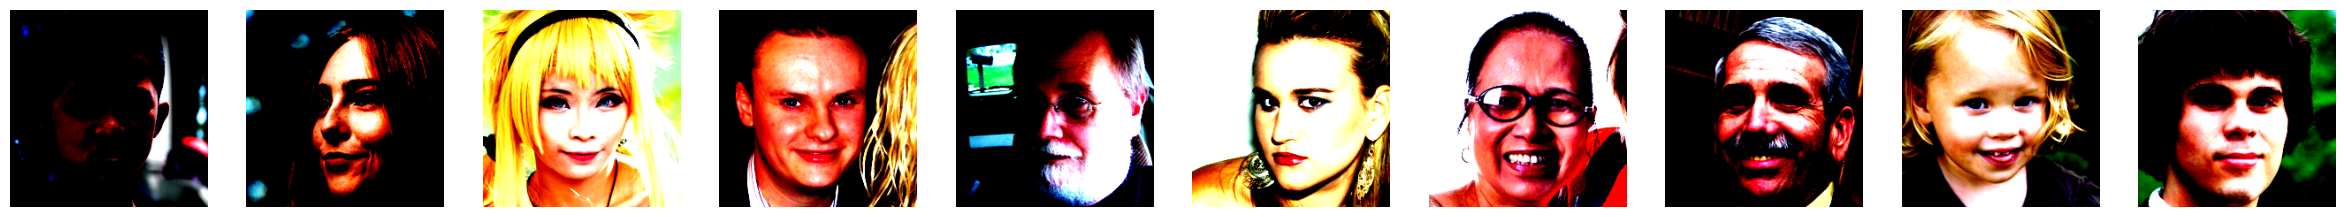

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(index_great), figsize=(30, 15))

for i in range(0,10):
  image = np.transpose(test_dataset[index_great[i] - 1][0], (1, 2, 0))
  axes[i].imshow(image)
  axes[i].axis('off')  # Turn off axis


plt.show()

### predict: real image

In [ ]:
index_poor = np.argsort(test_loss)[::-1][:10]

In [ ]:
index_poor

array([2378,  577, 8025, 5970, 6399, 6470,  479, 6651, 5866, 5891])

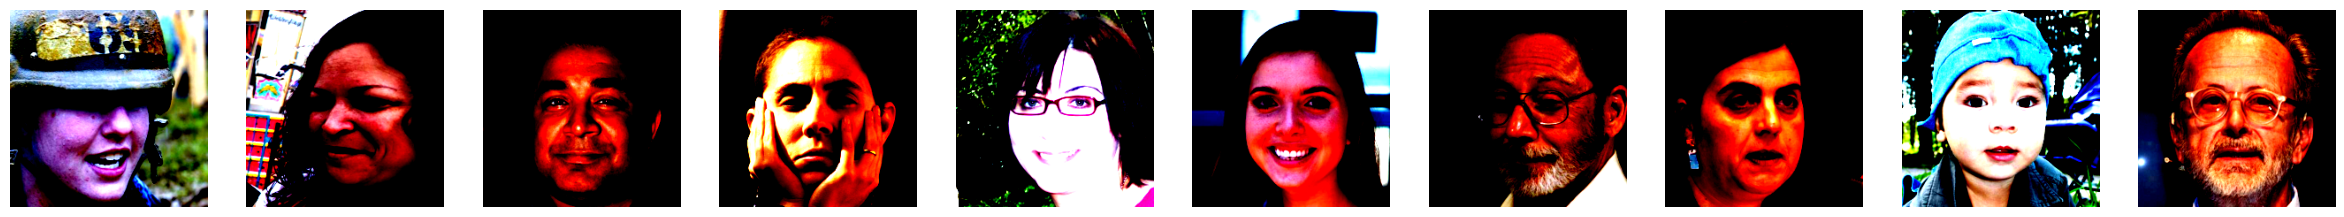

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(index_poor), figsize=(30, 15))

for i in range(0,10):
  image = np.transpose(test_dataset[index_poor[i] - 1][0], (1, 2, 0))
  axes[i].imshow(image)
  axes[i].axis('off')  # Turn off axis


plt.show()

## Real images

In [ ]:
test_loss_real = []

if gpu_available and use_gpu:
    model = model.cuda()

for i, (images, labels) in enumerate(test_dataset):
  if labels == 0:

    if gpu_available and use_gpu:
        images = images.cuda()

    output = model(images.unsqueeze(0))
              # image.shape = torch.Size([3, 224, 224])
              # .unsqueeze(0) -> torch.Size([1, 3, 224, 224])
                                            # 1 = batch_size
                                            # I want to enumerate each image at once
              # 0 mean position

      # convert labels to tensor so it can compare with the output
    labels = torch.tensor([labels])
    if gpu_available and use_gpu:
        labels = labels.cuda()

    loss = criterion(output.logits, labels) # label already in cuda, so only assign image/ model to cuda
                                            # the loss will in tensor

    test_loss_real.append(loss.item()) # extract value from tensor

In [ ]:
len(test_loss_real)

14000

### predict: real image

In [ ]:
index_great_real = np.argsort(test_loss_real)[::-1][-10:]
index_great_real

array([10417, 12414,  5016,  9245,  2469,  2993,  4939,  8507,  6052,
       10001])

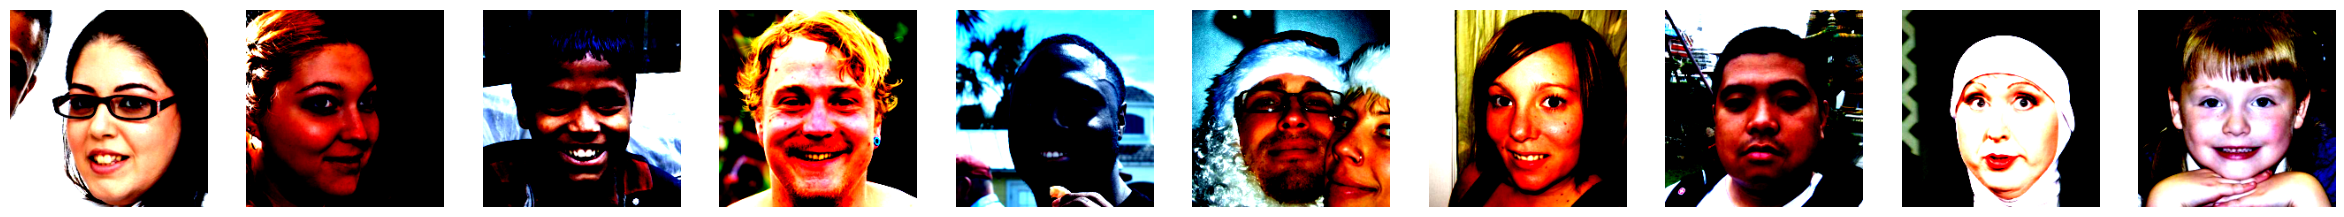

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(index_great_real), figsize=(30, 15))

for i in range(0,10):
  image = np.transpose(test_dataset[index_great_real[i] - 1][0], (1, 2, 0))
  axes[i].imshow(image)
  axes[i].axis('off')  # Turn off axis


plt.show()

### predict: AI-generated

In [ ]:
index_poor_real = np.argsort(test_loss_real)[::-1][:10]
index_poor_real

array([ 1689,  7840,  3616, 12829, 12825,  3194, 10828,  8794,  6745,
        1901])

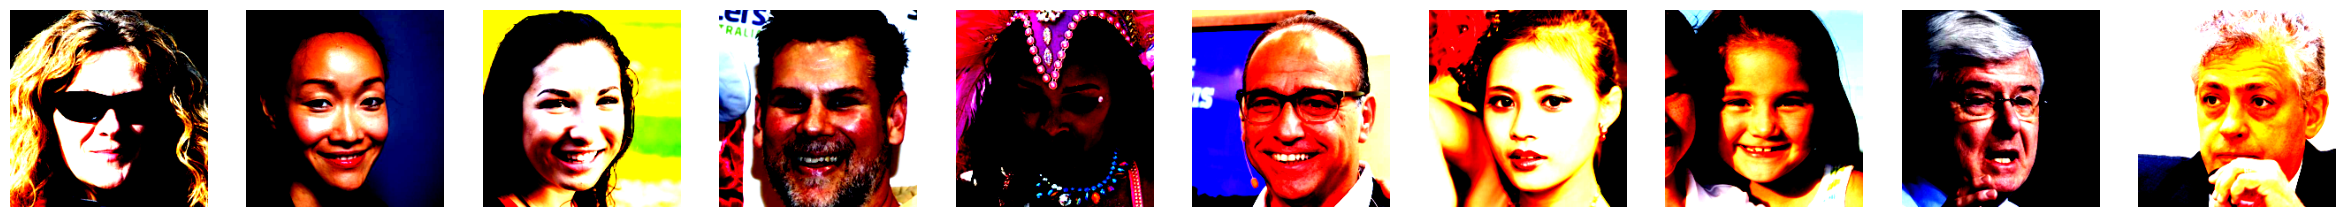

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(index_poor_real), figsize=(30, 15))

for i in range(0,10):
  image = np.transpose(test_dataset[index_poor_real[i] - 1][0], (1, 2, 0))
  axes[i].imshow(image)
  axes[i].axis('off')  # Turn off axis


plt.show()